In [1]:
!pip install torchvision

In [2]:
import torch
from torch.nn import functional as F
import torch.nn as nn

In [3]:
image = torch.rand(1,1,6,6)
kernal = torch.rand(3,1,3,3)

layer = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,padding=0,bias=False,stride=1)
layer.weight = nn.Parameter(kernal)
out1 = layer(image)
out2 = F.conv2d(image,kernal,bias=None,stride=1,padding=0)

print(out1)
print(out2)

tensor([[[[2.8725, 2.9791, 2.8451, 3.2598],
          [1.5834, 2.2868, 2.2163, 2.3240],
          [1.9528, 1.8900, 2.7294, 2.8177],
          [2.1519, 2.8117, 2.3707, 3.1362]],

         [[2.3480, 2.5075, 2.6388, 2.8814],
          [1.6967, 2.0140, 1.9807, 2.4145],
          [1.7242, 2.0565, 2.2836, 2.6575],
          [2.0377, 2.4815, 2.6684, 2.9646]],

         [[2.9389, 2.3812, 2.6551, 2.9868],
          [1.0657, 2.1505, 2.2072, 2.3153],
          [1.7677, 1.9853, 2.3822, 2.7316],
          [2.3333, 2.3485, 2.2670, 2.6806]]]], grad_fn=<ConvolutionBackward0>)
tensor([[[[2.8725, 2.9791, 2.8451, 3.2598],
          [1.5834, 2.2868, 2.2163, 2.3240],
          [1.9528, 1.8900, 2.7294, 2.8177],
          [2.1519, 2.8117, 2.3707, 3.1362]],

         [[2.3480, 2.5075, 2.6388, 2.8814],
          [1.6967, 2.0140, 1.9807, 2.4145],
          [1.7242, 2.0565, 2.2836, 2.6575],
          [2.0377, 2.4815, 2.6684, 2.9646]],

         [[2.9389, 2.3812, 2.6551, 2.9868],
          [1.0657, 2.1505, 2.2072

In [4]:
class MNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = nn.Sequential(
        nn.Conv2d(1,64,3),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2),
        nn.Conv2d(64,128,3),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2),
        nn.Conv2d(128,64,3),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2)
    )
    self.linear = nn.Sequential(
        nn.Linear(64,20,bias=True),
        nn.ReLU(),
        nn.Linear(20,10,bias=True)
    )
  def forward(self,x):
      features = self.cnn(x)
      batch_size = features.shape[0]
      return self.linear(features.view(batch_size,-1))

In [5]:
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transform
import torchvision

In [6]:
batch_size = 32

In [7]:
trainset = torchvision.datasets.MNIST(root= "./data/",download=True,train=True,transform=transform.ToTensor())
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 40.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.16MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
testset = torchvision.datasets.MNIST(root= "./data/",download=True,train=False,transform=transform.ToTensor())
testloader = DataLoader(testset,batch_size=batch_size,shuffle=False)

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
epochs = 5
model = MNIST().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

In [13]:
def one_epoch(index):
  total_loss = 0
  for i,(input,labels) in enumerate(trainloader):
    input, labels = input.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss/len(trainloader)*batch_size

0
40.57660346781413
1
7.821071329720815
2
4.927310633126894
3
3.82567173576355
4
3.220414133143425


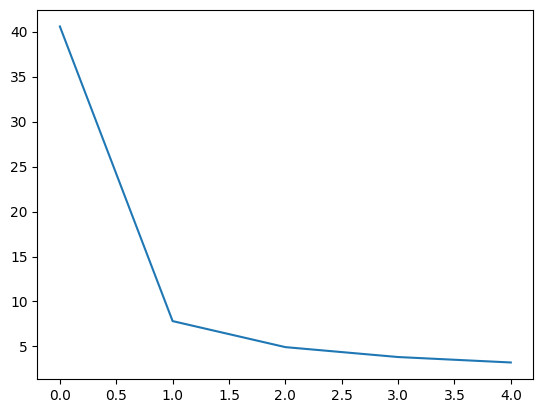

In [14]:
loss_list=[]
for epoch in range(epochs):
  print(epoch)
  epoch_loss = 0
  model.train(True)
  avg_loss=one_epoch(epoch)
  print(avg_loss)
  loss_list.append(avg_loss)

import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()

In [ ]:
model.eval()

In [19]:
from sklearn.metrics import confusion_matrix
allpred = []
alllabel = []
correct = 0
total = 0
for i,(input,labels) in enumerate(testloader):
    input, labels = input.to(device), labels.to(device)
    output = model(input)
    _,predicted = torch.max(output,dim=1)
    allpred.extend(predicted.cpu().numpy())
    alllabel.extend(labels.cpu().numpy())
    total+=labels.size(0)
    correct+=(predicted == labels).sum()
accuracy = 100*correct/total
print(accuracy)
conf_mat = confusion_matrix(alllabel,allpred)
print(conf_mat)

tensor(97.5000, device='cuda:0')
[[ 968    1    2    0    0    1    3    1    2    2]
 [   0 1128    2    1    0    1    3    0    0    0]
 [   2    2 1016    0    0    1    1    8    1    1]
 [   0    0    5  992    0    6    0    2    3    2]
 [   1    0    3    1  952    0    7    2    1   15]
 [   6    0    2    8    0  863    3    1    5    4]
 [   5    4    0    0    2    3  940    0    4    0]
 [   2    4   31   10    0    1    0  970    1    9]
 [   2    0    7    2    3    2    6    1  942    9]
 [   3    0    0    2    7    4    1    4    9  979]]


In [17]:
total_params = 0
for name,param in model.named_parameters():
    params = param.numel()
    total_params += params
print(total_params)

149798
